In [2]:
import sys
import math
import string
import operator
import random
import collections
import datetime
import itertools
import functools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import IPython
import sympy as sp
import sympy.plotting as splt
import sympy.physics.vector as spv
import sympy.physics.mechanics as spm
import scipy.constants as spc

import IPython.display as ipd
spv.init_vprinting()
%matplotlib inline


In [3]:
print(f"""
    Python version {sys.version}
    IPython version {IPython.__version__}
    Numpy version {np.__version__}
    mathplotlib version {matplotlib.__version__}
    Pandas version {pd.__version__}
    Seaborn version {sns.__version__}
    """
      )



    Python version 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
    IPython version 8.4.0
    Numpy version 1.23.3
    mathplotlib version 3.5.2
    Pandas version 1.4.4
    Seaborn version 0.12.0
    


In [4]:
def directory(obj):
    return [
        str for str in dir(obj)
        if callable(getattr(obj, str)) & ~str.startswith('_')
    ]


In [5]:
print(IPython.utils.text.columnize(directory(ipd)))


Audio          JSON               Video               display_markdown      
Code           Javascript         VimeoVideo          display_pdf           
DisplayHandle  Latex              YouTubeVideo        display_png           
DisplayObject  Markdown           clear_output        display_pretty        
FileLink       Math               display             display_svg           
FileLinks      Pretty             display_html        publish_display_data  
GeoJSON        ProgressBar        display_javascript  set_matplotlib_close  
HTML           SVG                display_jpeg        set_matplotlib_formats
IFrame         ScribdDocument     display_json        update_display        
Image          TextDisplayObject  display_latex     



In [6]:
print(IPython.utils.text.columnize(dir(sp.S)))


Catalan           Naturals            __dir__            __ne__             
ComplexInfinity   Naturals0           __doc__            __new__            
Complexes         NegativeInfinity    __eq__             __reduce__         
EmptySequence     NegativeOne         __format__         __reduce_ex__      
EmptySet          One                 __ge__             __repr__           
EulerGamma        Pi                  __getattr__        __setattr__        
Exp1              Rationals           __getattribute__   __sizeof__         
GoldenRatio       Reals               __gt__             __slots__          
Half              TribonacciConstant  __hash__           __str__            
IdentityFunction  UniversalSet        __init__           __subclasshook__   
ImaginaryUnit     Zero                __init_subclass__  _classes_to_install
Infinity          __call__            __le__             false              
Integers          __class__           __lt__             register           

In [7]:
HALF = sp.S.Half
PI = sp.pi
E = sp.exp
POSITIVEINFINITY = sp.S.Infinity


# Support Functions

In [8]:
def reference_frame(
    frame: str,
    x=r'\imath', y=r'\jmath', z=r'\mathbf k'
) -> spv.ReferenceFrame:
    return spv.RAOreference_frame(
        frame, latexs=(
            fr'\; {{}}^\mathcal {frame} \hat {x}',
            fr'\;{{}}^\mathcal {frame} \hat {y}',
            fr'\: {{}}^\mathcal {frame} \hat {{z}}'
        )
    )


def RAOreference_frame(
    frame: str,
    x=r'e_1', y='e_2', z=r'e_3'
) -> spv.ReferenceFrame:
    return spv.ReferenceFrame(
        frame, latexs=(
            fr'\; {{}}^{frame} \hat {x}',
            fr'\;{{}}^{frame} \hat {y}',
            fr'\: {{}}^{frame} \hat {z}'
        )
    )


def vector(F: spv.ReferenceFrame, rx, ry, rz=0) -> spv.Vector:
    return rx*F.x + ry*F.y + rz*F.z


def vector_cos(
    F: spv.ReferenceFrame, magnitude,
    anglex, angley, anglez=sp.pi/2
) -> spv.Vector:
    return (magnitude *
            (sp.cos(anglex)*F.x
             + sp.cos(angley)*F.y
             + sp.cos(anglez)*F.z
             )
            )


def vector_line(
    start: spv.Vector, finish: spv.Vector
) -> spv.Vector:
    return finish - start


def vector_line_eqn(
    F: spv.ReferenceFrame, start: spv.Vector, finish: spv.Vector, kappa
) -> spv.Vector:
    return start + vector_line(start, finish).normalize()*kappa


def angle_between_vectors(a: spv.Vector, b: spv.Vector):
    return sp.acos(a.dot(b)/a.magnitude()/b.magnitude())


def make2Dsymbols(symbol_list):
    return [
        sp.symbols(f"{ch}_x:y", real=True)
        for ch in symbol_list
    ]


F, E = make2Dsymbols(['F', 'E'])
assert str(F) == '(F_x, F_y)'
assert str(E) == '(E_x, E_y)'


# Physics Vector

In [9]:
E = RAOreference_frame("E", "E_1", "E_2","E_3")
E.x, E.y, E.z

In [10]:
A = RAOreference_frame("A" )

A.x, A.y, A.z

In [11]:
c = sp.symbols("c_{{1:4}{1:4}}")
c

## DCM

The orientation of a specific frame relative to its parent

In [12]:
A_DCM_E = sp.Matrix(3,3, c)
A_DCM_E

⎡c_{{1}{1}}  c_{{1}{2}}  c_{{1}{3}}⎤
⎢                                  ⎥
⎢c_{{2}{1}}  c_{{2}{2}}  c_{{2}{3}}⎥
⎢                                  ⎥
⎣c_{{3}{1}}  c_{{3}{2}}  c_{{3}{3}}⎦

__Orient Explicit__

Sets the orientation of this reference frame relative to a 
parent reference frame by explicitly setting the direction 
cosine matrix.

In [13]:
A.orient_explicit(E, A_DCM_E)

__Returns the direction cosine matrix__

The returned A matrix can be used A to express the orthogonal unit vectors 
of this frame in terms of the orthogonal unit vectors of otherframe.

Notice that for ${}^{\mathcal E} \mathbf {e}_2$ is represents in the second row of E.dcm(E')

In [14]:
E.dcm(A), E.y.express(A)

⎛⎡c_{{1}{1}}  c_{{1}{2}}  c_{{1}{3}}⎤, c_{{2}{1}} a_x + c_{{2}{2}} a_y + c_{{2
⎜⎢                                  ⎥                                         
⎜⎢c_{{2}{1}}  c_{{2}{2}}  c_{{2}{3}}⎥                                         
⎜⎢                                  ⎥                                         
⎝⎣c_{{3}{1}}  c_{{3}{2}}  c_{{3}{3}}⎦                                         

}{3}} a_z⎞
         ⎟
         ⎟
         ⎟
         ⎠

In [15]:
a, b = [sp.symbols(f'{_}_1:4') for _ in ['a', 'b']]
a, b 

In [16]:
E.dcm(A) # represent E unit in term of E'

⎡c_{{1}{1}}  c_{{1}{2}}  c_{{1}{3}}⎤
⎢                                  ⎥
⎢c_{{2}{1}}  c_{{2}{2}}  c_{{2}{3}}⎥
⎢                                  ⎥
⎣c_{{3}{1}}  c_{{3}{2}}  c_{{3}{3}}⎦

In [17]:
E.dcm(A)*sp.Matrix(3,1,a)

⎡a₁⋅c_{{1}{1}} + a₂⋅c_{{1}{2}} + a₃⋅c_{{1}{3}}⎤
⎢                                             ⎥
⎢a₁⋅c_{{2}{1}} + a₂⋅c_{{2}{2}} + a₃⋅c_{{2}{3}}⎥
⎢                                             ⎥
⎣a₁⋅c_{{3}{1}} + a₂⋅c_{{3}{2}} + a₃⋅c_{{3}{3}}⎦

In [18]:
(a[0]*A.x + a[1]*A.y + a[2]*A.z).express(E)

## Frames differentition DCM

![](./images/Example02-01.png)

In [19]:
R, omega, t = sp.symbols("R, omega, t", real=True, positive=True)
F = RAOreference_frame("F")
A = RAOreference_frame("A")
A.orient_axis(F, F.z, omega*t)

In [20]:
vecR_in_A = R*A.x

In [21]:
vecR_in_A.diff(t, F).express(F).simplify()

In [22]:
vecR_in_A.diff(t, A)

### Unit vectors in another frame

The following rows gives the unit vectors of $\mathcal A$ expressed in
$\mathcal F$

In [23]:
A.dcm(F)

⎡cos(ω⋅t)   sin(ω⋅t)  0⎤
⎢                      ⎥
⎢-sin(ω⋅t)  cos(ω⋅t)  0⎥
⎢                      ⎥
⎣    0         0      1⎦

In [24]:
vecR_in_A.express(F), (A.dcm(F))*sp.Matrix([R, 0, 0])

⎛R⋅cos(ω⋅t) f_x + R⋅sin(ω⋅t) f_y, ⎡R⋅cos(ω⋅t) ⎤⎞
⎜                                 ⎢           ⎥⎟
⎜                                 ⎢-R⋅sin(ω⋅t)⎥⎟
⎜                                 ⎢           ⎥⎟
⎝                                 ⎣     0     ⎦⎠

## Dynamic variables

![](./images/Example02-02.jpg/)

__With dynamic symbols__

In [25]:
omega, t = sp.symbols("Omega t", real=True, positive=True)
x, y, theta = spv.dynamicsymbols("x, y, theta", level=0)


In [26]:
theta.diff()

In [27]:
F = RAOreference_frame("F", x=r"E_x", y=r"E_y", z=r"E_z")
A = RAOreference_frame("A", x=r"e_x", y=r"e_y", z=r"e_z")
A.orient_axis(F, F.z, theta)

In [28]:
vecP = x*A.x + y*A.y

In [29]:
vecP.dt(A), vecP.dt(F)


In [30]:
vecP.dt(F).subs(theta.diff(), omega)


In [31]:
(vecP.dt(F)
 .dt(F)
 .subs(theta.diff().diff(), 0)
 .subs(theta.diff(), omega)
 .simplify()
)


----

In [33]:
t = sp.symbols("Omega t", real=True, positive=True)
x, y, theta = spv.dynamicsymbols("x, y, theta", level=0)
Omega = theta.diff()
x, y, theta, Omega

In [ ]:
F = RAOreference_frame("F", x=r"E_x", y=r"E_y", z=r"E_z")
A = RAOreference_frame("A", x=r"e_x", y=r"e_y", z=r"e_z")
A.orient_axis(F, F.z, theta)

In [ ]:
vecP = x*A.x + y*A.y

In [ ]:
vecP.dt(A), vecP.dt(F)


In [ ]:
vecP.dt(F).subs(theta.diff(), omega)


In [ ]:
(vecP.dt(F)
 .dt(F)
 .subs(theta.diff().diff(), 0)
 .subs(theta.diff(), omega)
 .simplify()
)


----

In [ ]:
F = RAOreference_frame("F", x=r"E_x", y=r"E_y", z=r"E_z")
A = RAOreference_frame("A", x=r"e_x", y=r"e_y", z=r"e_z")
A.orient_axis(F, F.z, theta)

In [ ]:
vecP = x*A.x + y*A.y

In [ ]:
vecP.dt(A), vecP.dt(F)


In [ ]:
vecP.dt(F).subs(theta.diff(), omega)


In [ ]:
(vecP.dt(F)
 .dt(F)
 .subs(theta.diff().diff(), 0)
 .subs(theta.diff(), omega)
 .simplify()
)


__With Functions of time__

__With Functions of time__

In [ ]:
omega, t = sp.symbols("Omega t", real=True, positive=True)
x, y, theta = sp.symbols("x, y, theta", cls=sp.Function)
x, y, theta, x(t), y(t), theta(t)


(x, y, theta, x(t), y(t), theta(t))

In [ ]:
F = RAOreference_frame("F", x=r"E_x", y=r"E_y", z=r"E_z")
A = RAOreference_frame("A", x=r"e_x", y=r"e_y", z=r"e_z")
A.orient_axis(F, F.z, theta(t))

In [ ]:
vecP = x(t)*A.x + y(t)*A.y
vecP

In [ ]:
(vecP.diff(t, F)
 .simplify()
 .subs(theta(t).diff(t), omega)
)

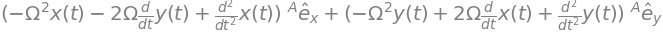

In [ ]:

(vecP.diff(t, F).diff(t, F)
 .simplify()
 .subs(theta(t).diff(t).diff(t), 0)
 .subs(theta(t).diff(t), omega)
 )


__Rotation Formulae__

$$
{}^{\mathcal A}\frac{d \mathbf v}{d t} = 
        {}^{\mathcal A}\frac{d \mathbf r}{d t} =
            {}^{\mathcal B}\frac{d \mathbf r}{d t} +
                {}^A{\mathbf \omega^B} \times \mathbf r 
$$

$$
{}^{\mathcal A} \mathbf v = 
    {}^{\mathcal B} \mathbf v +
        {}^A{\mathbf \omega^B} \times \mathbf r
$$


$$
{}^{\mathcal A} \mathbf a = 
    {}^{\mathcal B} \mathbf a 
        + {}^A \alpha^\mathcal{B} \times \mathbf r 
        + { 2 \cdot {}^A{\mathbf \omega^B} } \times {}^{\mathcal B} \mathbf v
        + x {}^A{\mathbf \omega^B} \times ({}^A{\mathbf \omega^B} \times \mathbf r²)
$$


In [ ]:
omega, t = sp.symbols("Omega t", real=True, positive=True)
x, y, theta = sp.symbols("x, y, theta", cls=sp.Function)
x, y, theta, x(t), y(t), theta(t)


(x, y, theta, x(t), y(t), theta(t))

In [ ]:
vecP = x(t)*A.x + y(t)*A.y
vecP

In [ ]:
vecP.diff(t, A)


In [ ]:
(vecP.diff(t,A) + spv.cross(theta(t).diff(t)*F.z, vecP)).express(A) #.simplify()